# Pulsar Timing with libstempo

(Credit: _Dr. Thankful Cromartie_)

![detection_flowchart](images/detection_flowchart.png)

## Introduction

The power of pulsar timing comes from the ability to precisely predict when pulses will arrive at our telescope. The "timing model" combines parameters describing how the pulsar spins, how the pulsar moves across the sky, how the pulsar orbits around a companion, and how the interstellar medium affects the intrinsic pulse as it propagates through. We can visualize this as follows:


![timing model](images/pulsar_timing_model_orbit_bincomp_LOS_ism.png)

We see that we must account for the position of the telescope on the Earth and as it goes around the Sun. Similarly, we need to account for where the pulsar is in its binary orbit. The arrows show that the two systems are moving with respect to each other in the Galaxy. And, as there is material in the interstellar medium, a single broadband pulse then spreads out in frequencies due to dispersion, such that longer wavelengths (red) arrive later than shorter wavelengths (blue).


![pulse train](images/pulse_train.png)

A good model (top) will be able to predict when the pulses arrive exactly whereas a bad model (bottom) will not. The difference between the observed time of arrival (TOA) of a pulse and the predicted arrival time is known as a timing residual, and plots of residuals help us visualize whether or not we have a good model or not.


In this exercise, you will see how different timing parameters change the timing residuals when they are slightly incorrect, and then slowly build up a good timing model. To do the analysis, you will use [libstempo](http://vallis.github.io/libstempo/), a wrapper for the [tempo2](http://www.atnf.csiro.au/research/pulsar/tempo2/) timing package. Along the way, you'll determine some interesting astrophysics about your pulsar.

This notebook is built in python 3. There are a few subtle, practical differences between 2 and 3. The primary one that you might encounter is that print must be done as a function print() rather than a statement.

In [1]:
# Useful imports
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
import libstempo as T
import libstempo.plot as LP
import libstempo.toasim as LT

We're going to use the functions defined below just for ease. You won't have to adjust them for any part of this exercise but can if you'd like to at any point in time.

`par_writer()` will write out a pulsar parameter (par) file. It will include a couple of basic lines at top and then will simply write whatever string you want to the file. We'll see more about this in a moment. By default, it will output a par file with the name "mytiming.par".

`tim_writer()` will write out simulated TOAs based on information in the par file. If the par and tim file match up, then you should have a good fit of the residuals. What you'll be doing in this activity is simulating TOAs and then seeing how a modified par file affects the fit, so there will be a set of runs of `par_writer()`, `tim_writer()`, and then `par_writer()` again. By default, this will output a tim file with the name "mytiming.tim".

`make_pulsar()` will take a par file and simulate TOAs into a (tim) file. You can open the tim file if you'd like but it won't be required for this exercise. By default, it reads from a par file called "mytiming.par" and then will output a tim file with the name "mytiming.tim". You can see internally how libstempo will simulate TOAs. 

In [2]:
# Helper functions
def par_writer(string,basename='mytiming'):
    output = """MODE 1
    PSR      J0000+0000
    PEPOCH    50000.0
    """
    output += string
    with open(basename+".par",'w') as FILE:
        FILE.write(output)
        
        
def tim_writer(basename="mytiming"):
    psr = LT.fakepulsar(parfile=basename+".par",
                        obstimes=np.arange(53000,56000,14.0)+np.random.normal(0,1),  # observe every 14+-1 days
                        toaerr=0.1) #toaerr gives the error bars

    LT.add_efac(psr,efac=1.0,seed=1234) #adds the corresponding scatter (multiplied by 1)
    psr.savetim(basename+".tim")

To begin, we're going to make an unmoving, spinning pulsar with spin period $P = 15$~ms, or a spin frequency of $f = 66.66\bar{6}$ Hz, which we will use because it is often the more fundamental quantity (written as "F0" in a par file, this formulation is better for using libstempo). First we'll make the par file and then we'll simulate the corresponding arrival times.

In [3]:
par_writer("""
F0       66.66666667
""") 
tim_writer()

[tempo2Util.C:396] Warning: [PAR1] Have not set a position epoch. The period epoch will be used instead. mytiming.par
[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. mytiming.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


Now let's use libstempo to show how well the spin period fits the TOAs.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/665907038.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


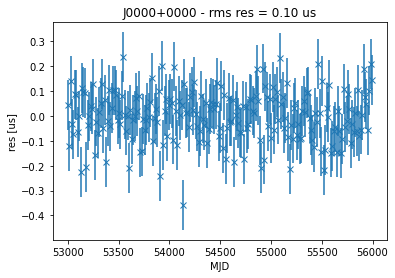

In [4]:
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

What do you notice about the residuals? Do you think this is a reasonable fit? Why or why not?

Answer: The residuals are generally on the order of $\sim 0.1~\rm{\mu s}$. This seems reasonable to me, given that the residuals are on the order of $10^{-5}$ smaller than the actual timing measurement. Additionally, the residuals seem to be roughly stochastically distributed around $0$.

Now let's see what happens when we change the spin frequency ever so slightly. Try taking the code below and slightly changing the spin frequency.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/1620790082.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


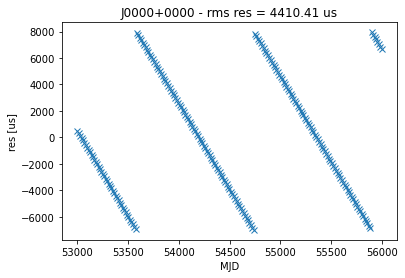

In [7]:
par_writer("""
F0       66.66666666
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

Now let's learn how to fit the parameter for the spin period. To do this, we add a "1" after the value of the parameter, which for par files means that the parameter should be fit for. A "0" means to hold that value fixed, which is the same as not having a number there at all as we've been doing.

To do the fit we run `psr.fit()` after we load the `tempopulsar` object, like so:

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3994607090.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


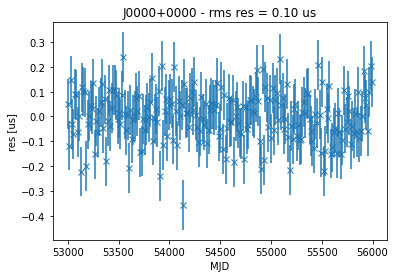

In [8]:
par_writer("""
F0       66.666666671   1
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
psr.fit()
LP.plotres(psr)

How well did the fit do? To see what the value of the spin period is, you have to print out the value of the spin frequency, which is $1/P$. To show that value, print `psr['F0']`. In general, you can print `psr[<parameter name>]`. Try that below.

In [9]:
print(psr['F0'])

tempo2 parameter F0 (fitted): 66.66666666999999791 +/- 6.0562597121310536757e-15


We know that since pulsars are emitting radiation, they are losing energy and thus are slowing down. The spin frequency derivative, $\dot{f}$, is written in the par file as `F1`. The units on $\dot{f}$ are typically hertz per seconds, that is, how many hertz the pulsar is slowing down every second. As you might expect, it's a very tiny number. Let's first build our new par file and make a new set of TOAs

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/1562698424.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


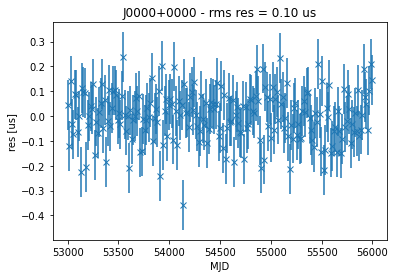

In [10]:
par_writer("""
F0       66.66666667
F1      -1e-19
""")
tim_writer()
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

Next, now change the spin frequency derivative ever so slightly, from $-1 \times 10^{-19}$ to $-1.1 \times 10^{-19}$.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/242206076.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


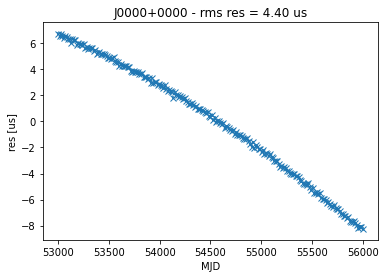

In [11]:
par_writer("""
F0       66.66666667
F1       -1.1e-19
""") #make changes here
#Don't rewrite .tim
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

What do you notice about the shape of the residuals? When $\dot{f}$ is incorrect, do the residuals look the same as when $f$ is incorrect?

Answer: Instead of a stochastic distribution of timing residuals they have a roughly linear distribution.

Now try to fit both parameters and print the values of the parameters. How do they compare to the true values? Is the fit good?

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/2432531181.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


tempo2 parameter F0 (fitted): 66.66666667000002633 +/- 7.0382290593608999153e-14
tempo2 parameter F1 (fitted): -1.00057932023248557103e-19 +/- 1.8039243731612615494e-22


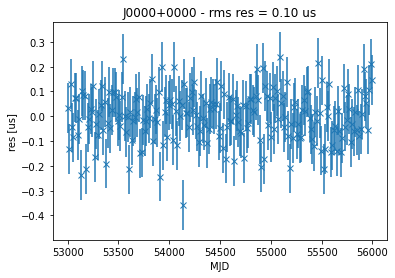

In [12]:
par_writer("""
F0       66.66666667 1
F1       -1.0e-19 1
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
psr.fit()
LP.plotres(psr)
print(psr['F0'])
print(psr['F1'])

Answer: The fit appears to be very good compared to our expected values.

Great, now you are an expert timer! Let's now add in the position of the pulsar. We'll write in the right ascension (RA) and declination (DEC) of one of NANOGrav's best pulsars (in the J2000 coordinate system) by adding to the par file   
`RAJ    19:09:00`   
and   
`DECJ    -37:44:00`.   
Copy the code above, make a new par and tim file, and plot the results. As usual, you should start off with a good fit.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3573910606.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


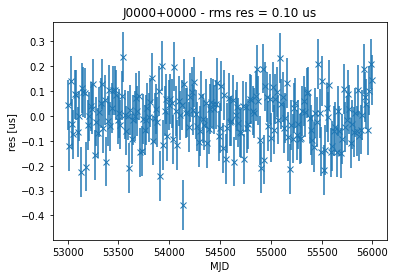

In [13]:
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
""")
tim_writer()
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

Now add 1 milliarcsecond (0.001) to the declination and see how that affects the fit.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/1682437908.py:7: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


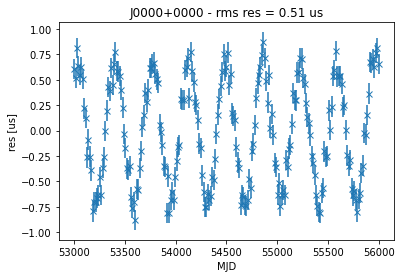

In [14]:
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00.001
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

What do you notice about the fit? What is the timescale of the variation? Any ideas why?

Answer: The variation timescale is clearly sinusoidal. Considering that the pulsar position has been made to be incorrect, this likely reflects the motion of the Earth relative to the pulsar, which is no longer accounted for correctly.

If you would like to investigate the residuals more closely, you can use   
`psr.toas()`  
to get the dates of the observations,   
`psr.residuals()`   
to get the value of the residuals, and 
`psr.toaerrs`   
in case you need the error bars (which will all be the same for this exercise by construction). Feel free to use numpy and matplotlib to investigate further.

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


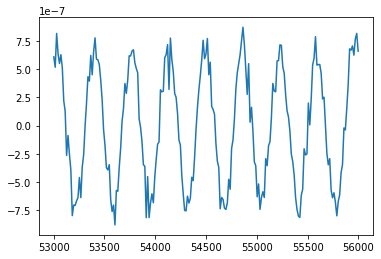

In [17]:
# Some space for you to work
dates = psr.toas()
residuals = psr.residuals()
errs = psr.toaerrs
print(errs)
matplotlib.pyplot.plot(dates, residuals)
# matplotlib.pyplot.errorbar(dates, residuals, xerr = None, yerr = errs)
matplotlib.pyplot.show()

Again, let's now fit for all of the parameters. Do you get a good fit at the end?

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/2844336429.py:7: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


tempo2 parameter F0 (fitted): 66.66666667000002633 +/- 7.067414509813796496e-14
tempo2 parameter F1 (fitted): -1.00054981106956352635e-19 +/- 1.8114524222155174202e-22
tempo2 parameter RAJ (fitted): 5.013458276359832766 +/- 2.7140294739882527724e-11
tempo2 parameter DECJ (fitted): -0.65857090441653964863 +/- 7.341891903421806418e-11


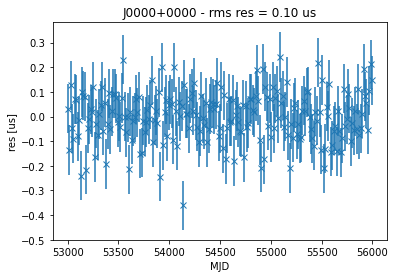

In [18]:
par_writer("""
F0    66.66666667       1
F1    -1.1e-19             1
RAJ     19:09:00         1
DECJ    -37:44:00.001     1
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
psr.fit()
for parameter in ['F0','F1','RAJ','DECJ']:
    print(psr[parameter])
LP.plotres(psr)

Note that if you print out the values of RAJ and DECJ, you will see them in units of radians, which may not be the most helpful.

The pulsar is at some distance from us, which produces a parallax. The units on the parallax are in milliarcseconds (mas). A pulsar with a parallax (PX) of 1 mas is at a distance of 1 kpc (kiloparsec). Let's put a pulsar at 0.5 kpc away, so it will have a parallax of 2.0 mas. Then let's see what happens when the pulsar is plotted with the wrong parallax, let's say 2.5 mas.

Instead of making two separate cells, let's condense our work into one cell. Now just call `par_writer()` with the appropriate values, then `tim_writer()`, then `par_writer()` again with the slightly adjusted parallax before plotting the residuals.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3319100542.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3319100542.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


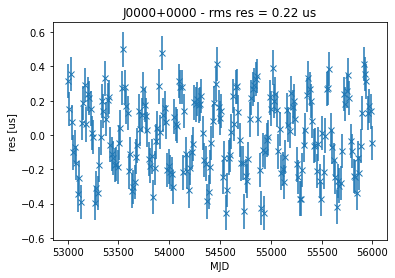

In [19]:
del psr
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2
""")
tim_writer()

psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")

par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2.5
""")

psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
LP.plotres(psr)

What do you notice about the fit? What is the timescale of the variation?

Answer: This also has sinusoidal behavior, though it is much smaller than before. However this could reflect the same motion of the Earth as before, as the variation timescale looks like it is on the order of half a year.

In [20]:
# Some space for you to work
# Timescale is a lot more ambiguous here, less than half a year

It turns out that the "why" of this timescale is a little bit more complicated than for an incorrect pulsar position. It has to do with the fact that the pulsar emission arriving at the solar system is not a plane wave but there is some curvature to it. 

Yet again, let's fit all of the parameters. Then print out the parallax value. How does the precision on this value compare to some of the others you've examined?

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3353851873.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


tempo2 parameter PX (fitted): 2.0026300236094818352 +/- 0.017124537727532807008


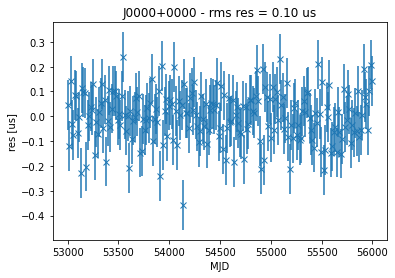

In [21]:
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2.5 1
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
psr.fit()
LP.plotres(psr)
print(psr['PX'])

Let's add one more set of astrometric terms, the proper motion in the RA and DEC directions. These are given in units of milliarcseconds per year (mas/yr). In the par file, we write `PMRA` and `PMDEC`. Set the true PMRA to 50.0 and the PMDEC to 0.0 just for ease. Then simulate your TOAs, mae a new par file with PMRA set to 50.1, and plot the results.

What do you notice about the residuals now? What is happening to the timescale of the variation? Any ideas as to why the structure of the residuals looks the way it does?

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/1934699685.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/1934699685.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


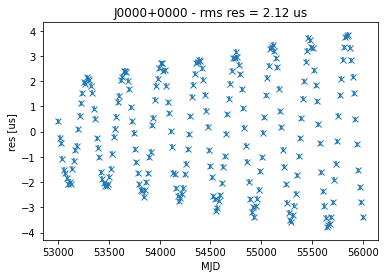

In [22]:
del psr
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2
PMRA       50.0
PMDEC       0.0
""")
tim_writer()
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")

par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2
PMRA       50.1
PMDEC       0.0
""")

psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")

LP.plotres(psr)

Once again, let's do the fit! Check to see if the values of the proper motion make sense.

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_31379/3562548901.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")


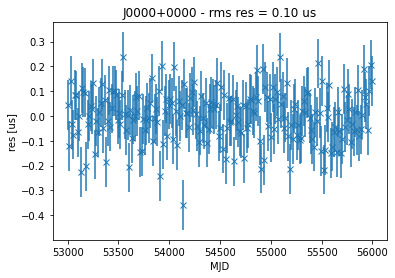

In [23]:
par_writer("""
F0       66.66666667
F1      -1e-19
RAJ       19:09:00
DECJ       -37:44:00
PX       2 
PMRA       50.1 1
PMDEC       0.0 1
""")
psr = T.tempopulsar(parfile='mytiming.par',timfile="mytiming.tim")
psr.fit()
LP.plotres(psr)

Excellent! You now have a description of this pulsar that accounts for the spin dynamics of the pulsar and the astrometry. Let's do some science with our numbers!

First, to make things easy, let's convert from $f$ and $\dot{f}$ to $P$ and $\dot{P}$. We have by definition that the spin period and frequency are related by $P = 1/f$. Using some calculus, then we have that

$$\frac{dP}{df} = -\frac{1}{f^2}$$

and therefore

$$\dot{P} = -\frac{\dot{f}}{f^2}$$.

Use the value of $P$ given above (or re-calculate it) and calculate $\dot{P}$. Note that the units of $\dot{P}$ are seconds per seconds.

In [24]:
P = 1/66.66666667
F = 66.66666667
Fdot = -1e-19
Pdot = -Fdot /F**2
print(Pdot) #rev/s

2.249999999775e-23


Let's calculate the amount of energy lost by the system, given by (see Lorimer & Kramer 2005)

$$\dot{E} = 4 \pi^2 I \dot{P} P^{-3} \simeq 3.95 \times 10^{31}~\mathrm{erg~s^{-1}}\left(\frac{\dot{P}}{10^{-15}}\right)\left(\frac{P}{\mathrm{s}}\right)^{-3}$$

How does this compare to the luminosity of the Sun ($4.0 \times 10^{33}~\mathrm{ergs~s^{-1}}$)?

In [25]:
# Some space for you to work
Edot = 4.95 * 10 ** 31 * (Pdot /10**-15) * (P)**-3
print(Edot) #Several orders of magnitude less than sun

3.300000000164999e+29


Now let's calculate the surface magnetic field of the pulsar, given by

$$ B_s = 3.2 \times 10^{19}~\mathrm{G} \sqrt{P \dot{P}} \simeq 10^{12}~\mathrm{G}~\left(\frac{\dot{P}}{10^{-15}}\right)^{1/2} \left(\frac{P}{\mathrm{s}}\right)^{1/2} $$

For reference, Earth's magnetic field is usually around $\lesssim 1~\mathrm{G}$!

In [26]:
Bs = (10**(12)) * (Pdot / 10**(-15))**.5 * P**.5
print(Bs)

18371173.069495995
